In [1]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp

# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

Database connection ok


In [12]:
# Whole ship cabling progress (weekly)
# Predictors:
# GT
# prototype
# Nothing (for mean)
# Algorithms:
# K-NN Regressor
# Mean

#get ship data
cursor.execute("SELECT project_id, gross_tonnage, prototype FROM projects")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]
ship_features = dict(zip(ships, data[:, [1, 2]]))
# init regression models
models = dict()
models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
models['3-NN Regression'] = KNeighborsRegressor(3, weights='distance')
models['Mean'] = DummyRegressor(strategy='mean')


# init cable intervals to zero
cursor.execute("UPDATE progress SET y_true=0")
cursor.commit()
# set real cable intervals
cursor.execute(
    "UPDATE progress SET progress.y_true=intervals.cable_count FROM ("
    " SELECT rw, ship_readiness.project_id, sum(amount) as cable_count FROM ship_readiness"
    " WHERE ship_readiness.rw IS NOT NULL"
    " AND running LIKE 'Y%'"
    " GROUP BY ship_readiness.project_id, rw) intervals"
    " WHERE progress.project_id=intervals.project_id AND progress.wk=intervals.rw"
)
cursor.commit()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):

        X_train = []
        y_train = []
        for i in train_i:
            train_ship = ships[i]
            cursor.execute(
                "SELECT y_true FROM progress WHERE project_id = {}"
                .format(train_ship)
            )
            data = np.array(cursor.fetchall())
            X_train.append(ship_features[train_ship])
            y_train.append(data[:, 0])
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        y_train = y_train/y_train.sum(axis=1)[:, None]
        scaler = pp.MinMaxScaler()
        X_train = scaler.fit_transform(X_train) #normalize features

        X_test = []
        y_test = []
        for i in test_i:
            test_ship = ships[i]
            cursor.execute(
                "SELECT y_true FROM progress WHERE project_id = {}"
                .format(test_ship)
            )
            data = np.array(cursor.fetchall())
            X_test.append(ship_features[train_ship])
            y_test.append(data[:, 0])
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_test = y_test/y_test.sum(axis=1)[:, None]
        X_test = scaler.transform(X_test) #normalize features
        
        # fit the model
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        #plt.plot(y_test[1, :], 'r')
        #plt.plot(preds[1, :], 'b')
        #plt.show()
        # evaluate
        score = np.abs((y_test - preds)).sum()/4.0
        scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)

In [8]:
# Whole ship design progress (weekly)
# Predictors:
# GT
# Nothing (for mean)
# Algorithms:
# K-NN Regressor
# Mean

#get ship data
cursor.execute("SELECT project_id, gross_tonnage FROM projects")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]
ship_gt = dict(zip(ships, data[:, 1]))

# init regression models
models = dict()
models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
models['3-NN Regression'] = KNeighborsRegressor(3, weights='distance')
models['Mean'] = DummyRegressor(strategy='mean')


# init cable intervals to zero
cursor.execute("UPDATE progress SET y_true=0")
cursor.commit()
# set real cable intervals
cursor.execute(
    "UPDATE progress SET progress.y_true=intervals.cable_count FROM ("
    " SELECT pw, ship_readiness.project_id, sum(amount) as cable_count FROM ship_readiness"
    " WHERE ship_readiness.pw IS NOT NULL"
    " GROUP BY ship_readiness.project_id, pw) intervals"
    " WHERE progress.project_id=intervals.project_id AND progress.wk=intervals.pw"
)
cursor.commit()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):

        X_train = []
        y_train = []
        for i in train_i:
            train_ship = ships[i]
            cursor.execute(
                "SELECT y_true FROM progress WHERE project_id = {}"
                .format(train_ship)
            )
            data = np.array(cursor.fetchall())
            X_train.append(ship_gt[train_ship])
            y_train.append(data[:, 0])
        X_train = np.array(X_train).reshape((-1, 1))
        y_train = np.array(y_train)
        y_train = y_train/y_train.sum(axis=1)[:, None]
        scaler = pp.MinMaxScaler()
        X_train = scaler.fit_transform(X_train) #normalize features

        X_test = []
        y_test = []
        for i in test_i:
            test_ship = ships[i]
            cursor.execute(
                "SELECT y_true FROM progress WHERE project_id = {}"
                .format(test_ship)
            )
            data = np.array(cursor.fetchall())
            X_test.append(ship_gt[train_ship])
            y_test.append(data[:, 0])
        X_test = np.array(X_test).reshape((-1, 1))
        y_test = np.array(y_test)
        y_test = y_test/y_test.sum(axis=1)[:, None]
        X_test = scaler.transform(X_test) #normalize features
        
        # fit the model
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        #plt.plot(y_test[1, :], 'r')
        #plt.plot(preds[1, :], 'b')
        #plt.show()
        # evaluate
        score = np.abs((y_test - preds)).sum()/4.0
        scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)

In [7]:
# Whole ship cabling progress (monthly)
# Predictors:
# GT
# Nothing (for mean)
# Algorithms:
# K-NN Regressor
# Mean

#get ship data
cursor.execute("SELECT project_id, gross_tonnage FROM projects")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]
ship_gt = dict(zip(ships, data[:, 1]))

# init regression models
models = dict()
models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
models['3-NN Regression'] = KNeighborsRegressor(3, weights='distance')
models['Mean'] = DummyRegressor(strategy='mean')


# init cable intervals to zero
cursor.execute("UPDATE progress SET y_true=0")
cursor.commit()
# set real cable intervals
cursor.execute(
    "UPDATE progress SET progress.y_true=intervals.cable_count FROM ("
    " SELECT rm, ship_readiness.project_id, sum(amount) as cable_count FROM ship_readiness"
    " WHERE ship_readiness.rm IS NOT NULL"
    " AND running LIKE 'Y%'"
    " GROUP BY ship_readiness.project_id, rm) intervals"
    " WHERE progress.project_id=intervals.project_id AND progress.mt=intervals.rm"
)
cursor.commit()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):

        X_train = []
        y_train = []
        for i in train_i:
            train_ship = ships[i]
            cursor.execute(
                "SELECT avg(y_true) FROM progress WHERE project_id = {} GROUP BY mt"
                .format(train_ship)
            )
            data = np.array(cursor.fetchall())
            X_train.append(ship_gt[train_ship])
            y_train.append(data[:, 0])
        X_train = np.array(X_train).reshape((-1, 1))
        y_train = np.array(y_train)
        y_train = y_train/y_train.sum(axis=1)[:, None]
        scaler = pp.MinMaxScaler()
        X_train = scaler.fit_transform(X_train) #normalize features

        X_test = []
        y_test = []
        for i in test_i:
            test_ship = ships[i]
            cursor.execute(
                "SELECT avg(y_true) FROM progress WHERE project_id = {} GROUP BY mt"
                .format(test_ship)
            )
            data = np.array(cursor.fetchall())
            X_test.append(ship_gt[train_ship])
            y_test.append(data[:, 0])
        X_test = np.array(X_test).reshape((-1, 1))
        y_test = np.array(y_test)
        y_test = y_test/y_test.sum(axis=1)[:, None]
        X_test = scaler.transform(X_test) #normalize features
        
        # fit the model
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        #plt.plot(y_test[1, :], 'r')
        #plt.plot(preds[1, :], 'b')
        #plt.show()
        # evaluate
        score = np.abs((y_test - preds)).sum()/4.0
        scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)

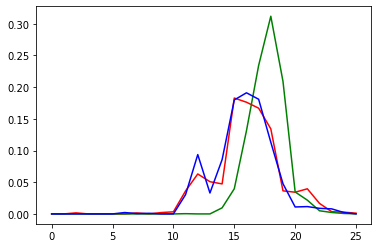

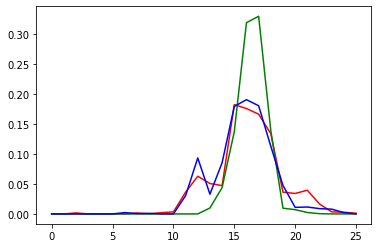

KeyboardInterrupt: 

In [26]:
# Whole ship cabling progress (monthly)
# Predictors:
# GT
# prototype
# Algorithms:
# K-NN Regressor

#get ship data
cursor.execute("SELECT project_id, gross_tonnage, prototype FROM projects")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]
ship_features = dict(zip(ships, data[:, [1, 2]]))

# init regression models
models = dict()
models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
models['6-NN Regression'] = KNeighborsRegressor(3, weights='distance')


# init cable intervals to zero
cursor.execute("UPDATE progress SET y_true=0")
cursor.commit()
# set real cable intervals
cursor.execute(
    "UPDATE progress SET progress.y_true=intervals.cable_count FROM ("
    " SELECT rm, ship_readiness.project_id, sum(amount) as cable_count FROM ship_readiness"
    " WHERE ship_readiness.rm IS NOT NULL"
    " AND running LIKE 'Y%'"
    " GROUP BY ship_readiness.project_id, rm) intervals"
    " WHERE progress.project_id=intervals.project_id AND progress.mt=intervals.rm"
)
cursor.commit()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):

        X_train = []
        y_train = []
        for i in train_i:
            train_ship = ships[i]
            cursor.execute(
                "SELECT avg(y_true) FROM progress WHERE project_id = {} GROUP BY mt"
                .format(train_ship)
            )
            data = np.array(cursor.fetchall())
            X_train.append(ship_features[train_ship])
            y_train.append(data[:, 0])
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        y_train = y_train/y_train.sum(axis=1)[:, None]
        scaler = pp.MinMaxScaler()
        X_train = scaler.fit_transform(X_train) #normalize features

        X_test = []
        y_test = []
        for i in test_i:
            test_ship = ships[i]
            cursor.execute(
                "SELECT avg(y_true) FROM progress WHERE project_id = {} GROUP BY mt"
                .format(test_ship)
            )
            data = np.array(cursor.fetchall())
            X_test.append(ship_features[train_ship])
            y_test.append(data[:, 0])
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_test = y_test/y_test.sum(axis=1)[:, None]
        X_test = scaler.transform(X_test) #normalize features
        
        # fit the model
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # evaluate
        score = np.abs((y_test - preds)).sum()/4.0
        if abs(score-0.2)<0.1:
            plt.plot(y_test[1, :], 'r')
            plt.plot(y_test[0, :], 'g')
            plt.plot(preds[1, :], 'b')
            plt.show()
        scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)

In [9]:
# Whole ship design progress (monthly)
# Predictors:
# GT
# Nothing (for mean)
# Algorithms:
# K-NN Regressor
# Mean

#get ship data
cursor.execute("SELECT project_id, gross_tonnage FROM projects")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]
ship_gt = dict(zip(ships, data[:, 1]))

# init regression models
models = dict()
models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
models['3-NN Regression'] = KNeighborsRegressor(3, weights='distance')
models['Mean'] = DummyRegressor(strategy='mean')


# init cable intervals to zero
cursor.execute("UPDATE progress SET y_true=0")
cursor.commit()
# set real cable intervals
cursor.execute(
    "UPDATE progress SET progress.y_true=intervals.cable_count FROM ("
    " SELECT pm, ship_readiness.project_id, sum(amount) as cable_count FROM ship_readiness"
    " WHERE ship_readiness.pm IS NOT NULL"
    " GROUP BY ship_readiness.project_id, pm) intervals"
    " WHERE progress.project_id=intervals.project_id AND progress.mt=intervals.pm"
)
cursor.commit()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):

        X_train = []
        y_train = []
        for i in train_i:
            train_ship = ships[i]
            cursor.execute(
                "SELECT avg(y_true) FROM progress WHERE project_id = {} GROUP BY mt"
                .format(train_ship)
            )
            data = np.array(cursor.fetchall())
            X_train.append(ship_gt[train_ship])
            y_train.append(data[:, 0])
        X_train = np.array(X_train).reshape((-1, 1))
        y_train = np.array(y_train)
        y_train = y_train/y_train.sum(axis=1)[:, None]
        scaler = pp.MinMaxScaler()
        X_train = scaler.fit_transform(X_train) #normalize features

        X_test = []
        y_test = []
        for i in test_i:
            test_ship = ships[i]
            cursor.execute(
                "SELECT avg(y_true) FROM progress WHERE project_id = {} GROUP BY mt"
                .format(test_ship)
            )
            data = np.array(cursor.fetchall())
            X_test.append(ship_gt[train_ship])
            y_test.append(data[:, 0])
        X_test = np.array(X_test).reshape((-1, 1))
        y_test = np.array(y_test)
        y_test = y_test/y_test.sum(axis=1)[:, None]
        X_test = scaler.transform(X_test) #normalize features
        
        # fit the model
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        #plt.plot(y_test[1, :], 'r')
        #plt.plot(preds[1, :], 'b')
        #plt.show()
        # evaluate
        score = np.abs((y_test - preds)).sum()/4.0
        scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)

In [ ]:
# Whole ship design progress (weekly)
# Predictors:
# GT
# Algorithms:
# K-NN Regressor

#get ship data
cursor.execute("SELECT project_id, gross_tonnage, prototype FROM projects")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]
ship_features = dict(zip(ships, data[:, [1, 2]]))

# init regression models
models = dict()
models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
models['3-NN Regression'] = KNeighborsRegressor(3, weights='distance')


# init cable intervals to zero
cursor.execute("UPDATE progress SET y_true=0")
cursor.commit()
# set real cable intervals
cursor.execute(
    "UPDATE progress SET progress.y_true=intervals.cable_count FROM ("
    " SELECT pw, ship_readiness.project_id, sum(amount) as cable_count FROM ship_readiness"
    " WHERE ship_readiness.pw IS NOT NULL"
    " GROUP BY ship_readiness.project_id, pw) intervals"
    " WHERE progress.project_id=intervals.project_id AND progress.wk=intervals.pw"
)
cursor.commit()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):

        X_train = []
        y_train = []
        for i in train_i:
            train_ship = ships[i]
            cursor.execute(
                "SELECT y_true FROM progress WHERE project_id = {}"
                .format(train_ship)
            )
            data = np.array(cursor.fetchall())
            X_train.append(ship_features[train_ship])
            y_train.append(data[:, 0])
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        y_train = y_train/y_train.sum(axis=1)[:, None]
        scaler = pp.MinMaxScaler()
        X_train = scaler.fit_transform(X_train) #normalize features

        X_test = []
        y_test = []
        for i in test_i:
            test_ship = ships[i]
            cursor.execute(
                "SELECT y_true FROM progress WHERE project_id = {}"
                .format(test_ship)
            )
            data = np.array(cursor.fetchall())
            X_test.append(ship_features[train_ship])
            y_test.append(data[:, 0])
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_test = y_test/y_test.sum(axis=1)[:, None]
        X_test = scaler.transform(X_test) #normalize features
        print(X_train)
        
        # fit the model
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        #plt.plot(y_test[1, :], 'r')
        #plt.plot(preds[1, :], 'b')
        #plt.show()
        # evaluate
        score = np.abs((y_test - preds)).sum()/4.0
        scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)

In [18]:
# Whole ship design progress (monthly)
# Predictors:
# GT
# prototype
# Algorithms:
# K-NN Regressor


#get ship data
cursor.execute("SELECT project_id, gross_tonnage, prototype FROM projects")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]
ship_features = dict(zip(ships, data[:, [1, 2]]))

# init regression models
models = dict()
models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
models['3-NN Regression'] = KNeighborsRegressor(3, weights='distance')



# init cable intervals to zero
cursor.execute("UPDATE progress SET y_true=0")
cursor.commit()
# set real cable intervals
cursor.execute(
    "UPDATE progress SET progress.y_true=intervals.cable_count FROM ("
    " SELECT pm, ship_readiness.project_id, sum(amount) as cable_count FROM ship_readiness"
    " WHERE ship_readiness.pm IS NOT NULL"
    " GROUP BY ship_readiness.project_id, pm) intervals"
    " WHERE progress.project_id=intervals.project_id AND progress.mt=intervals.pm"
)
cursor.commit()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):

        X_train = []
        y_train = []
        for i in train_i:
            train_ship = ships[i]
            cursor.execute(
                "SELECT avg(y_true) FROM progress WHERE project_id = {} GROUP BY mt"
                .format(train_ship)
            )
            data = np.array(cursor.fetchall())
            X_train.append(ship_features[train_ship])
            y_train.append(data[:, 0])
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        y_train = y_train/y_train.sum(axis=1)[:, None]
        scaler = pp.MinMaxScaler()
        X_train = scaler.fit_transform(X_train) #normalize features

        X_test = []
        y_test = []
        for i in test_i:
            test_ship = ships[i]
            cursor.execute(
                "SELECT avg(y_true) FROM progress WHERE project_id = {} GROUP BY mt"
                .format(test_ship)
            )
            data = np.array(cursor.fetchall())
            X_test.append(ship_features[train_ship])
            y_test.append(data[:, 0])
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_test = y_test/y_test.sum(axis=1)[:, None]
        X_test = scaler.transform(X_test) #normalize features
        
        # fit the model
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        #plt.plot(y_test[1, :], 'r')
        #plt.plot(preds[1, :], 'b')
        #plt.show()
        # evaluate
        score = np.abs((y_test - preds)).sum()/4.0
        scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)